# Convolutional Network for CIFAR-10
In this exercise we took the previously defined convolutional NN and applied it to the CIFAR-10 dataset. We changed the following with regards to the previous code:
- Imported the CIFAR-10 data as Python dict objects
- Changed the input image to 32 x 32 with a depth of 3.
- Increased the output channels of conv layer 1 to 12, conv layer 2 to 24 and conv layer 3 to 48. We kept the patch sizesand the size of the densly connected layer.
- Changed the learning rate parameters of our exponatial decay function.


In [90]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt
import math

# Used to load the python dataset
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

# load data, 60K trainset and 10K testset
# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=False, validation_size=0)

# load CIFAR-10 training data
training = dict()
for i in range(1,6):
    current = unpickle("/notebooks/CIFAR-10/data_batch_{}".format(i))
    training.update(current)
# load CIFAR-10 test data
test_data = unpickle("/notebooks/CIFAR-10/test_batch")

In [105]:
# 1. Define Variables and Placeholders
#the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 3072])
Y_ = tf.placeholder(tf.int32, [None])
lr = tf.placeholder(tf.float32)
pkeep = tf.placeholder(tf.float32)

# Conv layers
W1 = tf.Variable(tf.truncated_normal([5, 5, 3, 12], stddev=0.1))
B1 = tf.Variable(tf.ones([12])/10)
W2 = tf.Variable(tf.truncated_normal([5, 5, 12, 24], stddev=0.1))
B2 = tf.Variable(tf.ones([24])/10)
W3 = tf.Variable(tf.truncated_normal([4, 4, 24, 48], stddev=0.1))
B3 = tf.Variable(tf.ones([48])/10)

# Densely connected layer
W4 = tf.Variable(tf.truncated_normal([8 * 8 * 48, 200], stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10)

# Readout layer
W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)


# 2. Define the model
YY_ = tf.one_hot(Y_, 10)
XX = tf.reshape(X, [-1, 3072])
XXX = tf.reshape(XX, [-1, 32, 32, 3])

Y1 = tf.nn.relu(tf.nn.conv2d(XXX, W1, strides=[1, 1, 1, 1], padding='SAME') + B1)
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, 2, 2, 1], padding='SAME') + B2)
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, 2, 2, 1], padding='SAME') + B3)

YY = tf.reshape(Y3, shape=[-1, 8 * 8 * 48])                
                
Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
YY4 = tf.nn.dropout(Y4, pkeep)
Ylogits = tf.matmul(YY4, W5) + B5
Y = tf.nn.softmax(Ylogits)

# 3. Define the loss function  
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(Ylogits, YY_) # calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(cross_entropy)*100

# 4. Define the accuracy 
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(YY_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 5. Define an optimizer
train_step = tf.train.AdamOptimizer(0.005).minimize(cross_entropy)

# initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

test_data_items = test_data['data'][0:9999]
test_labels = test_data['labels'][0:9999]

def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # train each image
    batch_X = training['data'][i:(i+500)]
    batch_Y = training['labels'][i:(i+500)]
    
    # Define learning rate
    min_learning = 0.0005
    max_learning = 0.5
    decay_speed = 5000.0
    learning_rate = min_learning + (max_learning - min_learning) * math.exp(-i/decay_speed)
    # the backpropagation training step
    sess.run(train_step, feed_dict={XX: batch_X, Y_: batch_Y, lr: learning_rate, pkeep: 0.75})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: batch_X, Y_: batch_Y, pkeep: 1.0})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: test_data_items, Y_: test_labels, pkeep: 1.0})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)

# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 50000
epoch_size = 100
for i in range(0, training_iter, 500):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

49500


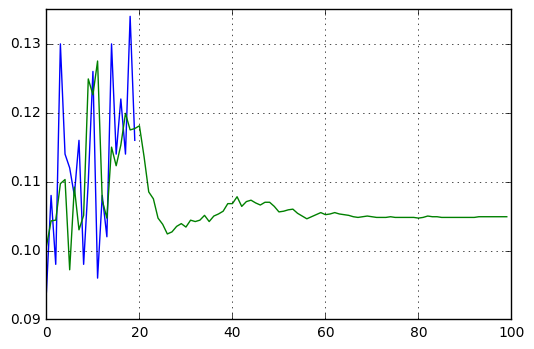

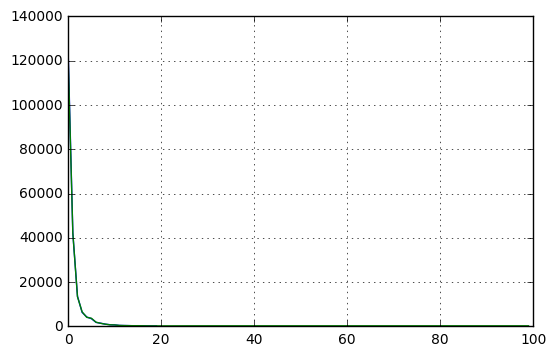

ValueError: x and y must have same first dimension

In [106]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a)
plt.plot(test_a)
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()